In [1]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import cm

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, Linear
import configs
from eval import eval

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
exp_dir = '../trained_models/03_stability_vis/'
p_files = os.listdir(exp_dir)

In [3]:
def get_ff_peaks(X, state_inputs, num_states):
    ff_peaks = []
    for x in X:
        ff = []
        for _state in np.arange(num_states):
            idxs = state_inputs==_state
            if idxs.size == 0:
                ff.append(0)
                continue
            ff.append(np.mean(x[idxs]))
        argmax = np.argmax(ff)
        ff_peaks.append(argmax)
    return ff_peaks

In [4]:
tick_mins = np.array([6, 8])
start_step = 1000
end_step = 1800

SF_1E-3.p


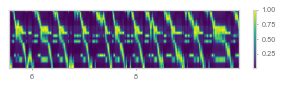

Oja_1E-3.p


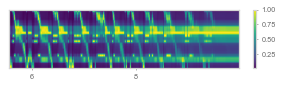

In [7]:
for p_file in ['SF_1E-3.p', 'Oja_1E-3.p']:
    with open(f'{exp_dir}{p_file}', 'rb') as f:
        results = pickle.load(f)
    outputs = results['outputs'].detach().numpy().T
    dset = results['dset']
    state_inputs = dset.state_inputs
    state_inputs = np.argmax(dset.state_inputs, axis=0)
    outputs = outputs[np.max(outputs, axis=1) > 1E-3]
    if 'SF' in p_file:
        argsort = np.argsort(get_ff_peaks(outputs, state_inputs, dset.num_states))
    outputs = outputs[argsort,:]
    outputs = outputs/(np.max(np.abs(outputs),axis=0)[np.newaxis,:])
    
    print(p_file)
    plt.figure(figsize=(4.25,1.25))
    plt.imshow(outputs[:,start_step:end_step], aspect="auto", cmap='viridis')
    plt.yticks([])
    plt.xticks((tick_mins*configs.dt_to_sec*60.)-start_step, tick_mins)
    #plt.xlabel('Minutes into Walk')
    plt.colorbar()
    plt.gca().spines[:].set_visible(True)
    plt.tight_layout()
    if 'SF' in p_file:
        plt.savefig('../figures/4cbottom.png', dpi=300, transparent=True)
    else:
        plt.savefig('../figures/4ctop.png', dpi=300, transparent=True)
    plt.show()